In [1]:
#used during development to pick up any changes to the imported scaling_framework_functions.py library
%load_ext autoreload
%autoreload 2

# Scaling Framework - TEST

Generates test data as nested polygons and demonstrates the framework

It uses spatial datasets (e.g., shapefiles or GeoPackages) to model spatial relationships (e.g., smaller patches within larger regions). Data attached to the smallest-scale features (the "building blocks") are then scaled up using spatial joins and weighted averages.

Hierarchical aggregation can occur stepwise: e.g., wetlands → catchments → entire river basin.

Metric aggregation uses a `weighted mean formula`  in several configurations.

```[]
        Aggregated_Value = Σ(Metric_i × Weight_i) / Σ(Weight_i)

        Where weights vary by method:
        - Area-weighted: Weight_i = Area_i (hectares)
        - Length-weighted: Weight_i = Length_i (meters)
        - Count-based: Weight_i = 1 (equal weighting)
        - Sum (of attributes): Weight_i = metric_value_i
        - Frequency-weighted: Weight_i = Frequency_i / Total_frequency
```

Results can be exported as CSV, shape files or GeoPackages.

In [2]:
%run create_test_data.py

Test data created successfully!
Files created in test:
- base_units.shp (4 rectangles)
- regions.shp (2 regions)
- basin.shp (1 basin)
- test_cover_data.csv (temporal data)


In [3]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

from scaling_framework_functions import (
    SpatialScale,
    plot_spatial_hierarchy
)

In [4]:
# =============================================================================
# TEST FILE PATHS
# =============================================================================
SPATIAL_PATH = Path("./test/")
DATA_PATH = Path("./test/")
OUTPUT_PATH = Path("./test/output/")

# =============================================================================
# Functional group rules for different base scales
# =============================================================================
# The rules dictionary maps the base scale types to a dictionary of functional group rules.
# Each group rule is a dictionary where the keys are the group names and values are
# keywords or phrases. Matching is always case insensitive.  used to reclassify existing classes.

GROUP_RULES = {
    "BaseUnits": {"vegetation": ["Forest", "Grassland"], "water": ["Wetland"]}
}

# =============================================================================
# PROJECTION FOR SPATIAL DATA
# shapefiles are loaded and re-projected if required to the default crs
# ensures spatial joins are working with data in the same projection
# =============================================================================
DEFAULT_CRS = "EPSG:4326"

## Load in the spatial data

The base scale is the smallest atomic unit that is to be aggregated up to larger scales

The aggregation scales are those larger scales - here representing larger regions, and the whole river basin that encompasses all base-scale units.

The SpatialScale object class represents a single spatial scale in the hierarchy, encapsulating spatial ecological data at one organizational level
(e.g., individual wetlands, river reaches, catchments) and provides methods for scale-appropriate aggregation and analysis.

### SpatialScale()

The SpatialScale constructor loads and validates spatial data (e.g. a shapefile) into a SpatialScale class object, automatically
detecting geometry types to compute ecologically-relevant weights.

The SpatialScale initialization includes:
1. Spatial data geometry checks and projection standardization
2. Geometry type detection (critical for appropriate weighting)
    - Polygons (habitats): Area in hectares
    - Lines (corridors): Length in meters
    - Points (sites): Count-based weighting

#### Arguments:
- name: Identifier for this spatial scale (e.g., 'wetlands', 'catchments')
- source: Path to shapefile containing spatial features
- unique_id_fields: Column(s) that uniquely identify each feature.
    Generally a single field but for compound keys use list: ['REGION_ID', 'SITE_ID']
- weighting_field: Column containing ecological weights. If None,
    weighting will be selected by geometry (Area weighted for polygons, Length weighted for lines, count for points)
- metric_fields: Columns containing ecological data to aggregate.
    Examples: ['NDVI', 'species_richness', 'water_quality']
- measure_multiplier: Scaling factor for weights (e.g., 0.0001 to
    convert m² to hectares)
- type_field: Column containing functional groups for ecological
    classification (e.g., 'WETLAND_TYPE', 'VEG_COMMUNITY_TYPE')
- default_crs: Coordinate reference system. Defaults to EPSG:3577
    (Australian Albers)
- is_base_scale: True for finest resolution data, False for
    aggregation targets

Loading BaseScale data from base_units.shp...
   Requested: ['SystemType', 'Area_Ha', 'UID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['UID', 'SystemType', 'Area_Ha', 'NDVI']
   Detected geometry type: polygon (4 features)
No metric fields specified. Inferred: ['NDVI']
Plotting BaseScale...


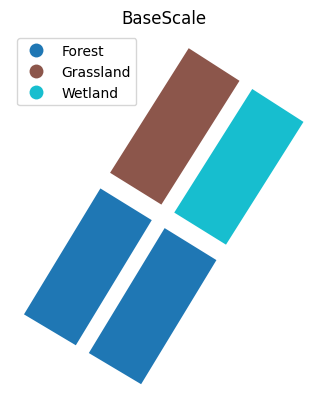

In [5]:
# Setup test environment
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Load the base spatial scale into a SpatialScale object
base_scale = SpatialScale(
    name="BaseScale",
    source=SPATIAL_PATH / "base_units.shp", # test data is four rectangles in a shape file
    unique_id_fields="UID",
    weighting_field="Area_Ha",
    #metric_fields="NDVI",  
    measure_multiplier=None,
    type_field="SystemType",
    is_base_scale=True,
    #default_crs="EPSG:4326"
)

# an inbuilt helper function "plot" draws the geometry of the SpatialScale object that was loaded

base_scale.plot()

## Create  aggregation scale objects

Additional spatial data sets are used to represent the larger scale features (here "regions" and "Basin" that contain the base-scale features loaded in the previous step)

The loading is the same, but here many of the options are not stated, relying on the defaults

In [6]:
#create  aggregation scale objects

region_scale = SpatialScale(
    "Regions",
    source = SPATIAL_PATH / "regions.shp",
    unique_id_fields="RegionID",
)

basin_scale = SpatialScale(
    "Basin",
    source = SPATIAL_PATH / "basin.shp",
    unique_id_fields="BasinID",
)



Loading Regions data from regions.shp...
   Requested: ['RegionID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['RegionID', 'RegionName']
   Detected geometry type: polygon (2 features)
No metric fields specified. Inferred: []
Loading Basin data from basin.shp...
   Requested: ['BasinID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['BasinID', 'BasinName']
   Detected geometry type: polygon (1 features)
No metric fields specified. Inferred: []


## Plot the spatial hierarchy for a visual check.


### .plot_spatial_hierarchy()
plot_spatial_hierarchy is a helper function to produce a simple overlay plot of the SpatialScale objects to show their geometry in 2D space.
#### Arguments:
- *args: SpatialScale objects where first is base scale, rest are aggregation scales

Plotting BaseScale with 2 aggregation scales...


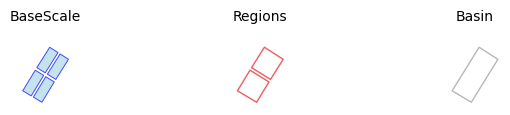

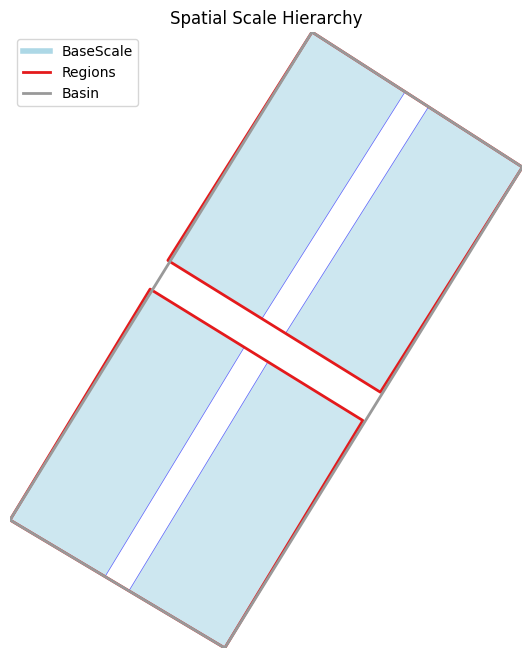

In [7]:

# the first item in the list is the base scale
plot_spatial_hierarchy(base_scale, region_scale, basin_scale)

## Optional: join additional data loaded from a CSV file

Requires a unique id column to match between the SpatialScale object `unique_id_field` so that the data can be joined to the spatial features.
If the data is in wide-form tabular format (wide-form) each row should be a 1:1 match with a unique_id in the base-scale data set. Unmatched rows will be dropped.
If the data is long-form it can be pivoted to wide-form and multiple columns of data will be joined to the base-scale data in a one-to-one relationship


### .join_data()

Load external tabular data and join it to the SpatialScale's data.

Supports:

1. Direct join if data is in wide format (one row per unique_id).
2. Pivoting long data (key-value) into wide before join.

#### Arguments:
- data_path: Path to the CSV or tabular data file.
- unique_id_field: Column in the CSV matching source unique ID. If None, defaults to the unique_id_fields of the parent class opject
- pivot_row_id: If pivoting, list of columns to use as index (the unique id).
- pivot_columns: If pivoting, column name whose values become new columns.
- pivot_values: If pivoting, column name containing values to fill.
- how: Type of join to perform (default "inner").
    - "inner"  - keeps only matching data and discards all items with no data. 
    - "left"  - keeps all the spatial data records and only loads data that matches from the CSV.
    - "right" - keeps all records from the CSV and drops any spatial objects that don't match




In [8]:
#Example loads vegetation fractional cover data for three years.
# The data is in long-form so needs to be pivoted to join to the base-scale (the 4 rectangles)

# Join to base scale
base_scale.join_data(
    data_path=DATA_PATH / "test_cover_data.csv",
    pivot_row_id="UID",
    pivot_columns="year",
    pivot_values="cover",
)

#inspect the first 5 rows of data without the geometry field 
print (base_scale.data.drop(columns=['geometry']).head())

No metric fields specified. Inferred: ['2020', '2021', '2022']
Joined external data from test\test_cover_data.csv on '['UID']'
    UID SystemType  Area_Ha  NDVI  2020  2021  2022
0  B001     Forest    200.0  0.80  0.80  0.82  0.78
1  B002    Wetland    200.0  0.60  0.60  0.58  0.62
2  B003     Forest    200.0  0.75  0.75  0.77  0.73
3  B004  Grassland    200.0  0.50  0.50  0.52  0.48


## Optional: reclass_map

A reclass_map is used to reclassify the different entities in the base-scale SpatialScale objects.  This is commonly done in ecology to represent a diverse group of features (or animals and plants) into functional groups.

This may be important where e.g.:

1. **Taxonomic grouping**: Species names may vary but belong to same family
2. **Habitat classification**: Detailed habitat types need broader groupings
3. **Management categories**: Administrative names need functional groupings

The use of substring matching handles common data challenges:
- Inconsistent naming conventions across datasets
- Hierarchical classification systems (species → genus → family)
- Regional variations in habitat terminology

The `reclass_map` is defined using a python dictionary of keywords or phrases to look for in the `type_field`. e.g. any objects with a `type_field` (defined at loading) value that has the words 'marsh', 'swamp' or 'wetland' will be reclassified into a single group called 'Wetlands' for the purpose of the analysis.

```python
# Functional group rules for different base scales
# The rules dictionary maps the base scale name to a dictionary of functional group rules.
# Each set of group rules is a dictionary where the keys are the functional group names
# keyword matching of types to groups is always case insensitive
# the structure is group_name: keywords in the values of the configured type_field

#this example has two different grouping "ANAE" and "Rivers" that can be called on by name

GROUP_RULES = {
    "ANAE": {
        "river red gum woodland": ["river red gum", "woodland"],
        "river red gum swamps and forests": ["river red gum"],
        "black box": ["black box"], #e.g. single black box class combining black box forests, black box woodlands
        "coolibah": ["coolibah"],
        "lignum": ["lignum"], # e.g. single lignum class combining lignum swamps, lignum floodplains
        "cooba": ["cooba"],
        "shrubland": ["f2.4: shrubland riparian zone or floodplain"],
        "submerged lake": ["permanent lake", "permanent wetland", "aquatic bed"],
        "tall reed beds": ["tall emergent marsh"],
        "grassy meadows": ["grass", "meadow"],
        "herbfield": ["forb marsh", "temporary wetland", "temporary lake"],
        "clay pan": ["clay"]
    },
    "Rivers": {
        "Permanent Lowland": ["permanent lowland"],
        "Temporary Lowland": ["temporary lowland"],
        "Other temporary": ["temporary transitional, "],
    }
}
```

Example output using ANAE

```test
Classification mapping applied: 'ANAE_TYPE' → 'regrouped'
============================================================
  'F1.10: Coolibah woodland and forest riparian zone or floodplain'  → 'river red gum woodland'
  'F1.11: River cooba woodland riparian zone or floodplain'          → 'river red gum woodland'
  'F1.12: Woodland riparian zone or floodplain'                      → 'river red gum woodland'
  'F1.2: River red gum forest riparian zone or floodplain'           → 'river red gum woodland'
  'F1.6: Black box forest riparian zone or floodplain'               → 'black box'

  ...
``


In [9]:
# Functional group rules (a very simple rules set named 'BaseUnits' is defined for the test data)

#This test mapping will simplify the types into fewer functional groups.
#  'Forest'      → 'vegetation'
#  'Grassland'   → 'vegetation'
#  'Wetland'     → 'water'


GROUP_RULES = {
    "BaseUnits": {
        "vegetation": ["Forest", "Grassland"],
        "water": ["Wetland"],
    }
}

## Perform Weighted Aggregation to Regions

Spatially join and aggregate base scale metrics into the target scale.

Aggregate ecological metrics from spatially joined data using
ecologically-appropriate weighting schemes.

ECOLOGICAL RATIONALE:
Different ecological metrics require different aggregation approaches:

1. **Area-weighted means**: For intensive properties that represent
    conditions per unit area (e.g., species density, vegetation health,
    water quality). Larger habitats contribute proportionally more.

2. **Length-weighted means**: For linear features like riparian zones
    where longer segments have greater ecological influence.

3. **Count-based aggregation**: For point observations where each
    monitoring site contributes equally regardless of spatial extent.

4. **Frequency-weighted means**: For compositional data where the
    relative abundance of different habitat types matters.

5. **Simple sums**: For extensive properties that accumulate across
    space (e.g., total habitat area, total species count).

        MATHEMATICAL FRAMEWORK:
        All methods use a unified weighted aggregation formula:

        Aggregated_Value = Σ(Metric_i x Weight_i) / Σ(Weight_i)

        Where weights vary by method:
        - Area-weighted: Weight_i = Area_i (hectares)
        - Length-weighted: Weight_i = Length_i (meters)
        - Count-based: Weight_i = 1 (equal weighting)
        - Frequency-weighted: Weight_i = Frequency_i / Total_frequency


### .aggregate_to()
The aggregate_to method is the guts of the framework, implementing the scaling-up logic.
Fine-resolution ecological data is scaled to larger spatial scales using weightings that 
to preserve ecological meaning and statistical validity.


#### Arguments:
- target_scale: SpatialScale object representing the aggregation
    target (e.g., catchments, management units)
- metric_columns: List of ecological metrics to aggregate.
    Examples: ['NDVI_mean', 'species_richness', 'pH', 'condition_score']
- method: Aggregation method selection:
    - `weighted_mean`: uses the weighting_field to weight the calculation of the mean
    - `area_weighted`: Polygon data - an alias that sets the weighting_field to Area_Ha by default
    - `length_weighted`: Line data -  an alias that sets the weighting field to Length_m by default
    - `count`: Equal weighting for all features
    - `sum`: Additive aggregation without averaging
    - `frequency_weighted`: Compositional weighting by type frequency of occurrence
- weighting_field: Override default weighting field.
    Used for custom weights e.g. population size, condition, priority
- how: Spatial join method ("intersects", "contains", "crosses", "overlaps", "within").
- group_by: Grouping variables for stratified analysis.
    Examples: ['ecosystem_type', 'conservation_status']
- reclass_map: Optional functional group classification.
    Dictionary mapping group_by names to alternative groupings using substring lists.
    Example: {'Wetland': ['marsh', 'swamp'], 'Forest': ['woodland', 'trees']}
 -new_class_field: Name for the reclassified functional groups column (default = "regrouped")
- keep_unmatched_types: Whether to retain or reject group_by types that
    don't match reclass_map patterns
- result_name: Storage key to save aggregated results in the target SpatialScale object as `target_scale.results[result_name]`


In [10]:
# Aggregate the base-scale to the regions (here each region contains 2 base-scale units)

# Geometry-weighted mean NDVI aggregated from base to regions
region_result = base_scale.aggregate_to(
    region_scale,                             #the larger scale we aggregate to
    metric_columns=[2020, 2021, 2022],        #calculate weighted means for each metric - in this case annual data
    method="weighted_mean",                   #base-scale is a polygon feature and an Area-weighted mean is the default
    reclass_map = GROUP_RULES["BaseUnits"],   #reclassify the base_scale types into functional groups
    result_name="2020-2022_weighted_means",  #store the results in the region_scale class
)

# the return value 'region_result' is a Result class object with properties
#   name
#   parent = the target SpatialScale object that holds the upscaled geometry
#   from_scale_name = name of the scale that was aggregated to the target
#   group_by = the key fields used to group results (ie functional group)
#   data =  the resulting data frame holding the output weighted measures without the geometry
#           This is for efficiency.  Data is joined to the geometry for export



Performing spatial join: BaseScale to Regions using 'intersects'
⚠ Warning: Renaming 1 conflicting columns in target scale: {'Area_Ha': 'Area_Ha_target'}
Reclassifying 'SystemType' into new groups 'reclass_map' using substring match from reclass map...

Classification mapping applied: 'SystemType' -> 'reclass_map'
  'Forest'      -> 'vegetation'
  'Grassland'   -> 'vegetation'
  'Wetland'     -> 'water'

Total unique types: 3
Functional groups created: 2

Aggregating by ['RegionID', 'reclass_map'] using 'weighted_mean' method
Processing 4 spatially joined records
Target metrics: ['2020', '2021', '2022']
Stored aggregated results as '2020-2022_weighted_means'


## print summary stats of the result data frame

## export the result data frame


In [11]:
# Summary stats of the generated metrics - may be useful to check row count and ranges
print(region_result.summary_stats())


#save the data as csv AND  shapefile
region_result.export(output_folder=OUTPUT_PATH, file_format=[".csv", ".shp"])  #could also include ".gpkg" for GeoPackage



       2020_arewm  2021_arewm  2022_arewm
count    3.000000    3.000000    3.000000
mean     0.625000    0.631667    0.618333
std      0.139194    0.144597    0.137508
min      0.500000    0.520000    0.480000
25%      0.550000    0.550000    0.550000
50%      0.600000    0.580000    0.620000
75%      0.687500    0.687500    0.687500
max      0.775000    0.795000    0.755000
exporting d:\Flow MER\mdb-scaling-up\test\output\2020-2022_weighted_means.csv
exporting d:\Flow MER\mdb-scaling-up\test\output\2020-2022_weighted_means.shp


d:\Flow MER\mdb-scaling-up\scaling_framework_functions.py:1936: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_df.to_file(out_file, driver="ESRI Shapefile")
d:\Flow MER\mdb-scaling-up\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'reclass_map' to 'reclass_ma'
  ogr_write(


In [12]:
# Example aggregating up the scale hierarchy  - region to Basin
# in the test data this is 2 rectangles up to 1 container rectangle

# Geometry-weighted mean NDVI aggregated from base to regions
region_results = base_scale.aggregate_to(
    region_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    weighting_field="NDVI",    #this time using a field value to define the weighting 
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="NDVI_weighted_mean",
)

Using 'NDVI' for 'NDVI_weighted' aggregation
Using cached spatial join: Regions_intersects
Reclassifying 'SystemType' into new groups 'reclass_map' using substring match from reclass map...

Classification mapping applied: 'SystemType' -> 'reclass_map'
  'Forest'      -> 'vegetation'
  'Grassland'   -> 'vegetation'
  'Wetland'     -> 'water'

Total unique types: 3
Functional groups created: 2

Aggregating by ['RegionID', 'reclass_map'] using 'weighted_mean' method
Processing 4 spatially joined records
Target metrics: ['2020', '2021', '2022']
Stored aggregated results as 'NDVI_weighted_mean'


# List all saved results

In [13]:

#list stored results for the region-scale
#results were stored because previous operations included a "result_name=" attribute
region_scale.save_results("list")


Available results:
  2020-2022_weighted_means       - scaled from: 'BaseScale' to Regions with grouping: ['RegionID', 'reclass_map'] -          3 rows ['RegionID', 'reclass_map', '2020_arewm', '2021_arewm', '2022_arewm']
  NDVI_weighted_mean             - scaled from: 'BaseScale' to Regions with grouping: ['RegionID', 'reclass_map'] -          3 rows ['RegionID', 'reclass_map', '2020_ndvwm', '2021_ndvwm', '2022_ndvwm']


# Perform Attribute-Weighted Aggregation to Regions

In [14]:
#Example - aggregate base scale directly to Basin
# (test is 4 rectangles aggregating to 1 container rectangle)

basin_result = base_scale.aggregate_to(
    basin_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="Area_weighted_mean",
)

Performing spatial join: BaseScale to Basin using 'intersects'
⚠ Warning: Renaming 1 conflicting columns in target scale: {'Area_Ha': 'Area_Ha_target'}
Reclassifying 'SystemType' into new groups 'reclass_map' using substring match from reclass map...

Classification mapping applied: 'SystemType' -> 'reclass_map'
  'Forest'      -> 'vegetation'
  'Grassland'   -> 'vegetation'
  'Wetland'     -> 'water'

Total unique types: 3
Functional groups created: 2

Aggregating by ['BasinID', 'reclass_map'] using 'weighted_mean' method
Processing 4 spatially joined records
Target metrics: ['2020', '2021', '2022']
Stored aggregated results as 'Area_weighted_mean'


# Frequency-Weighted Aggregation to Basin

In [15]:
# Frequency weighted - the weighting is the frequency of occurrence within each functional group
# not the size or magnitude

# Geometry-weighted mean NDVI aggregated from base to regions
basin_result= base_scale.aggregate_to(
    basin_scale,
    metric_columns=[2020, 2021, 2022],
    method="frequency_weighted",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="NDVI_frequency_weighted_mean",
)


Using cached spatial join: Basin_intersects
Reclassifying 'SystemType' into new groups 'reclass_map' using substring match from reclass map...

Classification mapping applied: 'SystemType' -> 'reclass_map'
  'Forest'      -> 'vegetation'
  'Grassland'   -> 'vegetation'
  'Wetland'     -> 'water'

Total unique types: 3
Functional groups created: 2

Aggregating by ['BasinID', 'reclass_map'] using 'frequency_weighted' method
Processing 4 spatially joined records
Target metrics: ['2020', '2021', '2022']
Stored aggregated results as 'NDVI_frequency_weighted_mean'


In [16]:
#list the various results that were saved into the target SpatialScale object

basin_scale.save_results("list")

Available results:
  Area_weighted_mean             - scaled from: 'BaseScale' to Basin with grouping: ['BasinID', 'reclass_map'] -          2 rows ['BasinID', 'reclass_map', '2020_arewm', '2021_arewm', '2022_arewm']
  NDVI_frequency_weighted_mean   - scaled from: 'BaseScale' to Basin with grouping: ['BasinID', 'reclass_map'] -          2 rows ['BasinID', 'reclass_map', '2020_frqwm', '2021_frqwm', '2022_frqwm']


In [17]:


#save the results to file as CSV, Shapefiles or GeoPackages
region_scale.save_results(OUTPUT_PATH, file_types=["csv", "shp", "gpkg"])

basin_scale.save_results(OUTPUT_PATH, file_types=["csv", "shp"])

exporting d:\Flow MER\mdb-scaling-up\test\output\2020-2022_weighted_means.csv
exporting d:\Flow MER\mdb-scaling-up\test\output\2020-2022_weighted_means.shp
exporting d:\Flow MER\mdb-scaling-up\test\output\2020-2022_weighted_means.gpkg
exporting d:\Flow MER\mdb-scaling-up\test\output\NDVI_weighted_mean.csv
exporting d:\Flow MER\mdb-scaling-up\test\output\NDVI_weighted_mean.shp
exporting d:\Flow MER\mdb-scaling-up\test\output\NDVI_weighted_mean.gpkg
exporting d:\Flow MER\mdb-scaling-up\test\output\Area_weighted_mean.csv
exporting d:\Flow MER\mdb-scaling-up\test\output\Area_weighted_mean.shp
exporting d:\Flow MER\mdb-scaling-up\test\output\NDVI_frequency_weighted_mean.csv
exporting d:\Flow MER\mdb-scaling-up\test\output\NDVI_frequency_weighted_mean.shp


d:\Flow MER\mdb-scaling-up\scaling_framework_functions.py:1936: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_df.to_file(out_file, driver="ESRI Shapefile")
d:\Flow MER\mdb-scaling-up\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'reclass_map' to 'reclass_ma'
  ogr_write(
d:\Flow MER\mdb-scaling-up\scaling_framework_functions.py:1936: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_df.to_file(out_file, driver="ESRI Shapefile")
d:\Flow MER\mdb-scaling-up\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'reclass_map' to 'reclass_ma'
  ogr_write(
d:\Flow MER\mdb-scaling-up\scaling_framework_functions.py:1936: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_df.to_file(out_file, driver="ESRI Shapefile")
d:\Flow MER\mdb-s

## Visualisation

Plotting BaseScale...


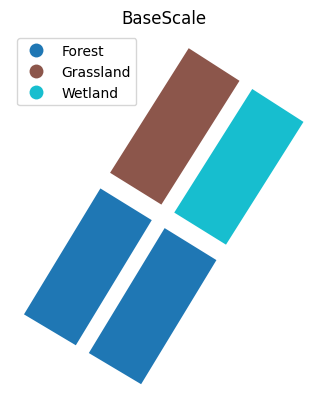

In [18]:
#plot the scale object using the defined "type_field"
base_scale.plot()



Plotting BaseScale...
Reclassifying 'SystemType' into new groups 'reclass_map' using substring match from reclass map...

Classification mapping applied: 'SystemType' -> 'reclass_map'
  'Forest'      -> 'vegetation'
  'Grassland'   -> 'vegetation'
  'Wetland'     -> 'water'

Total unique types: 3
Functional groups created: 2


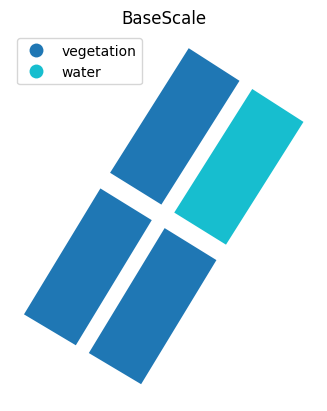

In [19]:
#plot the scale object applying reclass_map
base_scale.plot(reclass_map = GROUP_RULES["BaseUnits"])

In [20]:

#list all the column names
base_scale.data.columns



Index(['UID', 'SystemType', 'Area_Ha', 'NDVI', 'geometry', '2020', '2021',
       '2022', 'reclass_map'],
      dtype='object')

Plotting BaseScale...
Reclassifying 'SystemType' into new groups 'reclass_map' using substring match from reclass map...
⚠ Warning: removed existing 'reclass_map' column and re-applying group rules.

Classification mapping applied: 'SystemType' -> 'reclass_map'
  'Forest'      -> 'vegetation'
  'Grassland'   -> 'vegetation'
  'Wetland'     -> 'water'

Total unique types: 3
Functional groups created: 2
unique_id_fields: ['UID']
group_by: ['UID', 'reclass_map']
filter: None
Fields: ['2020']
Plots are grouped by ['reclass_map']


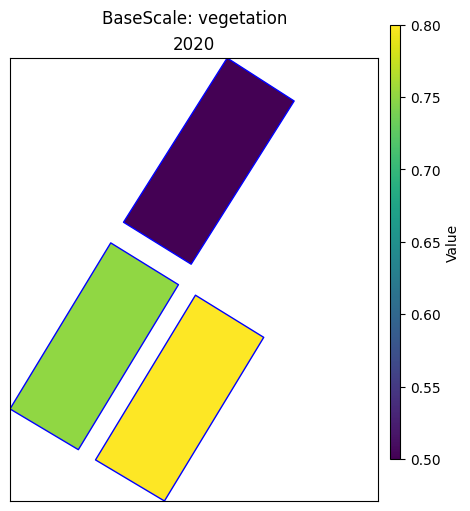

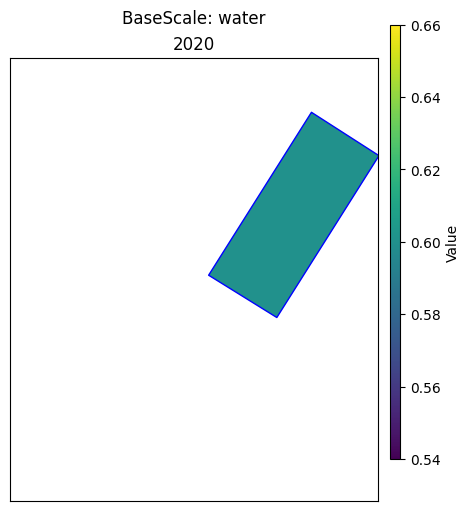

unique_id_fields: ['RegionID']
group_by: ['RegionID', 'reclass_map']
filter: None
Fields: ['2020_arewm']
Plots are grouped by ['reclass_map']


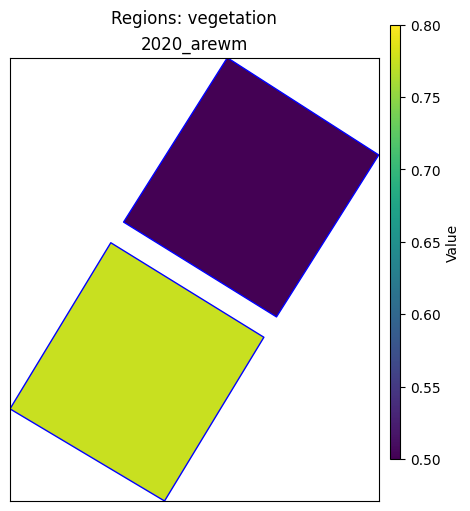

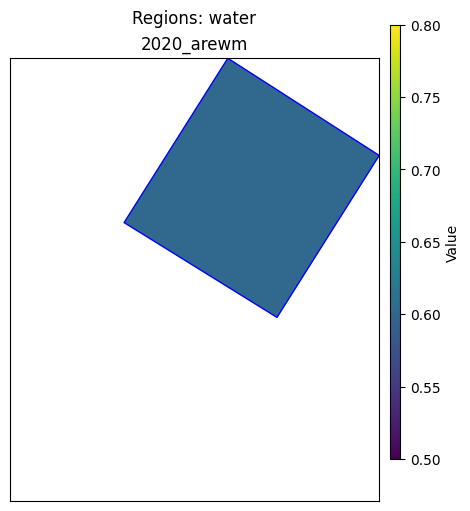

unique_id_fields: ['BasinID']
group_by: ['BasinID', 'reclass_map']
filter: None
Fields: ['2020_arewm']
Plots are grouped by ['reclass_map']


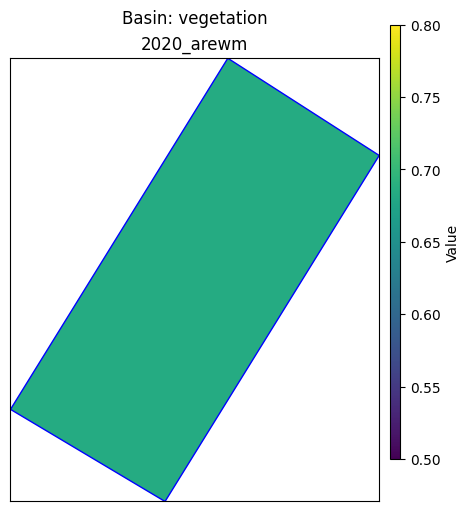

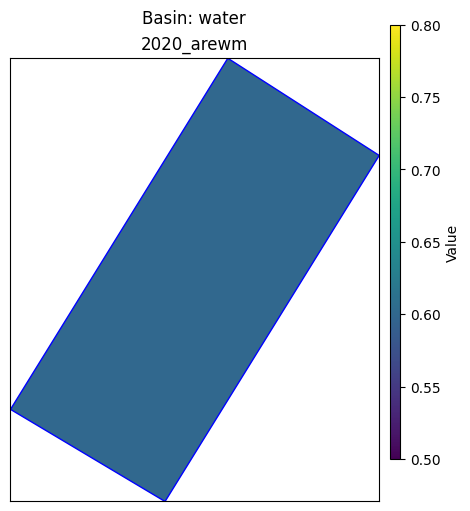

In [21]:
#Plot the results to visualise

#set a common min and max for the colour bar to visualise all plots on the same axes range
# if this was omitted the plots scale differently and can be misleading
vmin = 0.5
vmax = 0.8

#plot the scale object applying reclass_map
base_scale.plot(fields=[2020], reclass_map = GROUP_RULES["BaseUnits"], full_extent=True)

# we aggregated the base-scale to the region scale
#region_scale.results["2020-2022_weighted_means"].plot_unit(filter={"regrouped":"vegetation"}, vmin=vmin, vmax=vmax)
region_scale.results["2020-2022_weighted_means"].plot(fields=["2020_arewm"], vmin=vmin, vmax=vmax,  full_extent=True)

# we also aggregated the base scale to the basin-scale
#basin_scale.plot(result="Area_weighted_mean", field="2020_arewm", vmin=vmin, vmax=vmax)
basin_scale.results["Area_weighted_mean"].plot(fields=["2020_arewm"], vmin=vmin, vmax=vmax,  full_extent=True)
